# Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader

from datasets import FromNpDataset, ModelnetDataset
from models import PointnetEncoder, MLPDecoder, VAE, cd
from transforms import RandomRotation

# Prepare dataset

In [2]:
train_dataset = ModelnetDataset(transform=RandomRotation())
test_dataset = ModelnetDataset(transform=None)

train_loader = DataLoader(train_dataset, batch_size=24,
                        shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=24,
                        shuffle=True, num_workers=1)

# Visualize some data

In [3]:
def subplot_num(m, i, j):
    return i*m + j

def plot_samples(samples, n, m):
    fig = plt.figure(figsize=(18,18))
    for i in range(n):
        for j in range(m):
            idx = subplot_num(m, i, j)
            X, Y, Z = np.split(samples[idx], 3)
            ax = fig.add_subplot(n, m, idx+1, projection='3d')
            ax.scatter(X, Y, Z)        
    plt.show()
    
def apply_m_times(f, samples, m):
    applied = []
    for sample in samples:
        applied.append(sample)
        for i in range(m):
            applied.append(f(sample))
    return applied

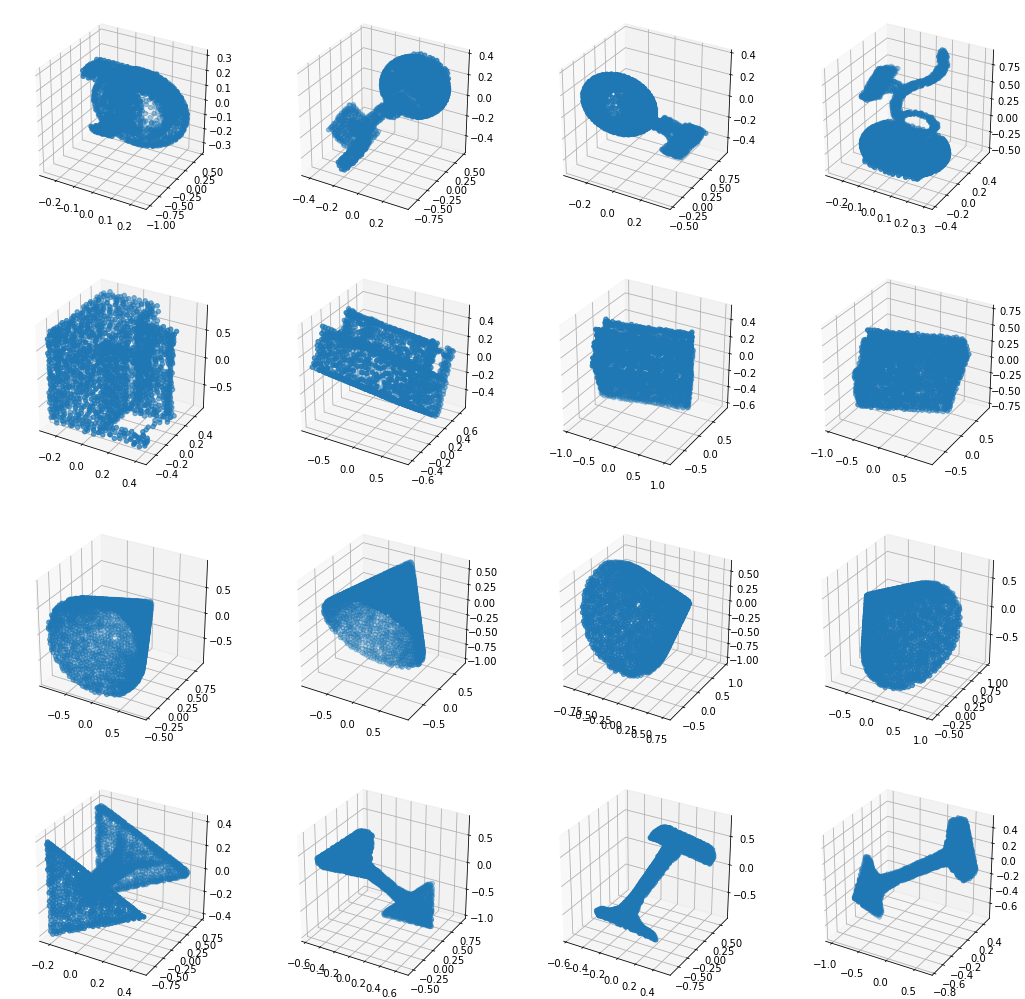

In [4]:
N, M = 4, 3
batch = next(iter(test_loader))
samples = apply_m_times(lambda x: RandomRotation()(x.numpy()), batch[:N], M)
plot_samples(samples, N, M+1)

# Experiments

http://openaccess.thecvf.com/content_cvpr_2018/papers/Yang_FoldingNet_Point_Cloud_CVPR_2018_paper.pdf

In [7]:
model = VAE.load_from_drive()

ModuleNotFoundError: No module named 'pointnet.model'; 'pointnet' is not a package

In [0]:
N, M = 4, 3
batch = next(iter(test_loader))
with torch.no_grad():
    samples = apply_m_times(lambda x: model(x.unsqueeze(0))[0].squeeze(0), batch[:N], M)
plot_samples(samples, N, M+1)

In [0]:
def reconstruct_dataset(model, loader):
    model.eval()
    model.to('cuda')
    recs = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.cuda()

            rec, _, _ = model(batch)
            recs.append(rec)
    
    model.to('cpu')
    return torch.stack(recs)

In [0]:
reconstructed = reconstruct_dataset(test_loader).numpy()

In [0]:
def nearest(x, loader):
    best = np.inf
    y = x.unsqueeze(0)
    with torch.no_grad():
        for batch in loader:
            batch = batch.cuda()
            if y.shape[0] != batch.shape[0]:
                y = x.expand(batch.shape[0], -1, -1).cuda()
            best = min(best, torch.min(cd(y, batch)).item())
    return best

def cov_single(idx, data, loader):
    sample = data[idx]
    
    data_excl = np.delete(train_data, idx, axis=0)
    dataset_excl = FromNpDataset(data_excl)
    loader_excl = DataLoader(dataset_excl, batch_size=24,
                                  shuffle=False, num_workers=1)
    
    data_d = nearest(sample, loader_excl)
    loader_d = nearest(sample, loader)
    
    return loader_d <= data_d

def cov(S, T):
    T_dataset = FromNpDataset(T)
    T_loader = DataLoader(T_dataset, batch_size=24,
                        shuffle=False, num_workers=1)
    N = data.shape[0]
    return sum([ cov_single(idx, S, T_loader) for idx in range(N) ]) / N

In [0]:
cov(train_data, reconstructed)